# Evaluating prolific test data

### This notebook contains functions for observing Barts zero shot classifier on prolific test data. The purpose of this notebook is to show what labels bart is most confident in. This is real data with real human labelling. 

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import numpy
import torch 
from transformers import BartForSequenceClassification, BartTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
import torch

In [4]:
def return_high_conf(data):
    LABELS = ["contradiction", "neutral", "entailment"]
    high_conf_list = []

    high_conf_dict = {
        "97-100": [],
        "95-97": [],
        "90-95": [],
        "80-90": [],
        "60-80": [],
        "40-60": [],
        "0-40": []
    }
    
    for _, row in data.iterrows():
        premise = row["premise"]
        hypothesis = row["hypothesis"]
        
        inputs = tokenizer(
            premise,
            hypothesis,
            return_tensors="pt",
            truncation=True,
            padding=True
        )

        scores = torch.softmax(model(**inputs).logits, dim=-1)
        scores = scores.squeeze().tolist()

        if scores[2] > .97:
            high_conf_dict["97-100"].append(premise)
        elif scores[2] >= .95 and scores[2] < .97:
            high_conf_dict["95-97"].append(premise)
        elif scores[2] >= .90 and scores[2] < .95:
            high_conf_dict["90-95"].append(premise)
        elif scores[2] >= .80 and scores[2] < .90:
            high_conf_dict["80-90"].append(premise)
        elif scores[2] >= .60 and scores[2] < .80:
            high_conf_dict["60-80"].append(premise)
        elif scores[2] >= .40 and scores[2] < .60:
            high_conf_dict["40-60"].append(premise)
        elif scores[2] < .40:
            high_conf_dict["0-40"].append(premise)
    
    return high_conf_dict

def value_to_num(score_dict):
    for key in score_dict.keys():
        new_val = len(score_dict[key])
        score_dict[key] = new_val

    return score_dict

def graph_score_distribution(len_score_dict, data_name=""):
    keys = list(len_score_dict.keys())
    values = list(len_score_dict.values())

    plt.figure()
    for i in range(len(keys)):
        plt.bar(keys[i], values[i])

    plt.title("confidence scores from current bart model - " + data_name)
    plt.xlabel("confidence level")
    plt.ylabel("text count")
    plt.show()

    return 
    
def get_unique_labeled_text(df):
    new_df = pd.DataFrame(columns=df.columns)
    count = 0
    
    for num in range(len(df['label'])):     
        if df['label'][num] == "entailment":            
            new_df.loc[count, 'premise'] = df.loc[num, 'premise']
            new_df.loc[count, 'hypothesis'] = df.loc[num, 'hypothesis']
            new_df.loc[count, 'label'] = df.loc[num, 'label']
            
            count += 1

    return new_df

In [5]:
test_data_entail_sixEight = pd.read_csv("entailment_test_data_sixEight.csv")
test_data_neutral_sixEight = pd.read_csv("neutral_test_data_sixEight.csv")

In [6]:
model_name = 'facebook/bart-large-mnli'
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForSequenceClassification.from_pretrained(model_name, num_labels=3)

/Users/joeycartwright/miniconda3/envs/csci477/lib/python3.11/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
conf_score_dict_sixEight = return_high_conf(test_data_entail_sixEight)
len_score_dict_sixEight = value_to_num(conf_score_dict_sixEight.copy())

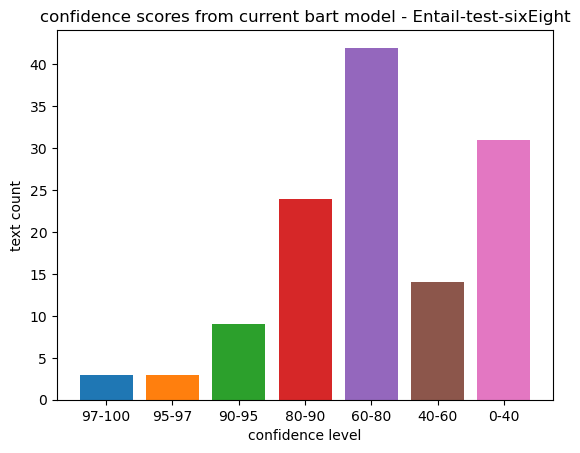

In [8]:
graph_score_distribution(len_score_dict_sixEight, data_name="Entail-test-sixEight")

In [9]:
conf_score_dict_neutral_sixEight = return_high_conf(test_data_neutral_sixEight)
len_score_dict_neutral_sixEight = value_to_num(conf_score_dict_neutral_sixEight.copy())

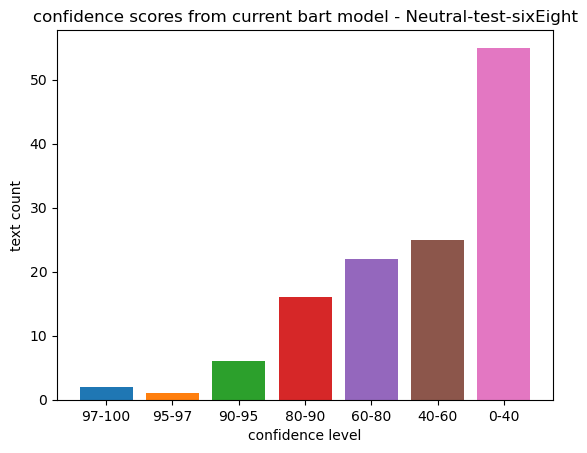

In [10]:
graph_score_distribution(len_score_dict_neutral_sixEight, data_name="Neutral-test-sixEight")

In [11]:
test_data_entail_og = pd.read_csv("entailment_test_data.csv")
test_data_neutral_og = pd.read_csv("nuetral_test_data.csv")

In [13]:
conf_score_dict_og = return_high_conf(test_data_entail_og)
len_score_dict_og = value_to_num(conf_score_dict_og.copy())

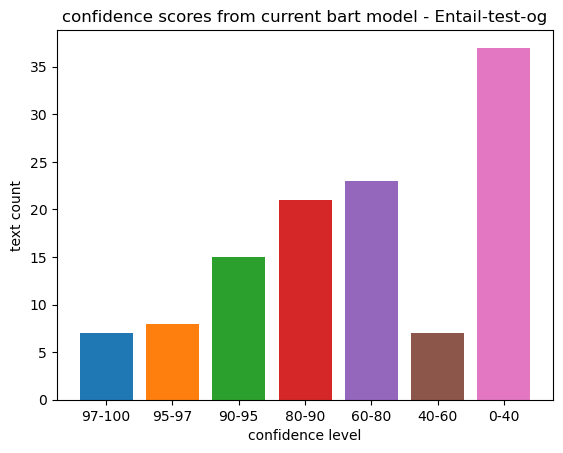

In [14]:
graph_score_distribution(len_score_dict_og, data_name="Entail-test-og")

In [15]:
conf_score_dict_neutral_og = return_high_conf(test_data_neutral_og)
len_score_dict_neutral_og = value_to_num(conf_score_dict_neutral_og.copy())

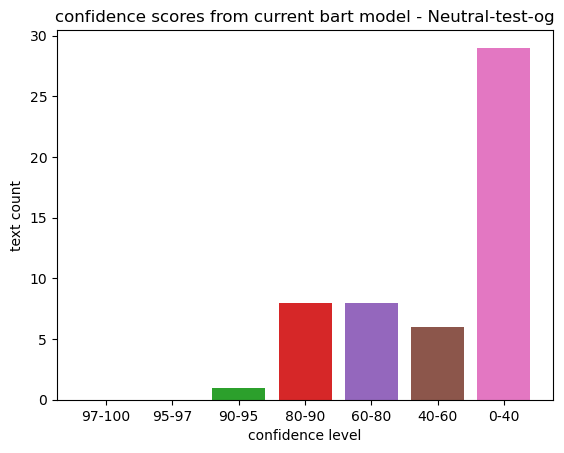

In [16]:
graph_score_distribution(len_score_dict_neutral_og, data_name="Neutral-test-og")

In [22]:
def create_word_clouds(score_text_list, data_name=""):
    fig_name = str(data_name + ".png")
    full_string_words = ' '.join(score_text_list)

    wordcloud = WordCloud(width=350,
                          height=150,
                          background_color='white',
                          colormap="coolwarm").generate(full_string_words)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(data_name + " - Word Cloud")
    plt.axis('off')
    plt.savefig(fig_name, dpi=300, bbox_inches="tight")
    plt.show()

    return 

def iterate_word_cloud(score_dict):
    for key in score_dict.keys():
        if len(score_dict[key]) > 0:
            create_word_clouds(score_dict[key], data_name=key)

    return 

## Entailment Word Clouds - sixEight

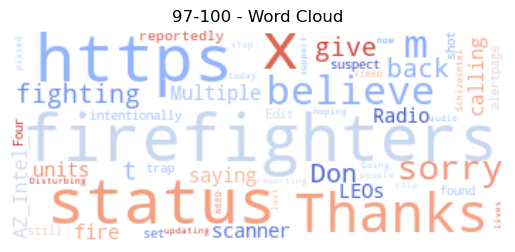

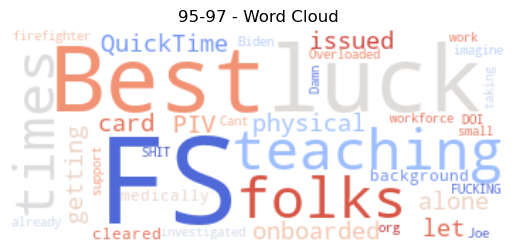

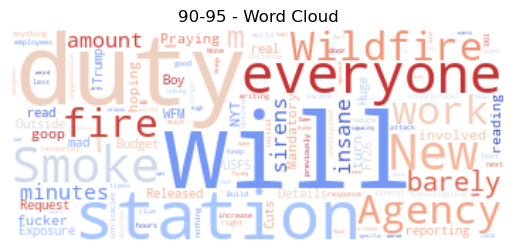

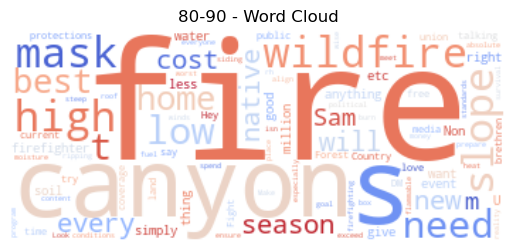

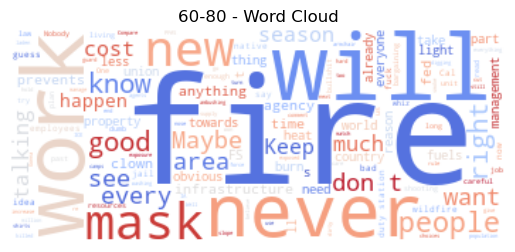

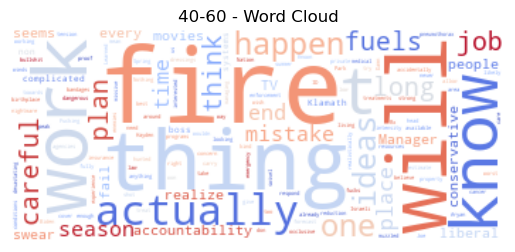

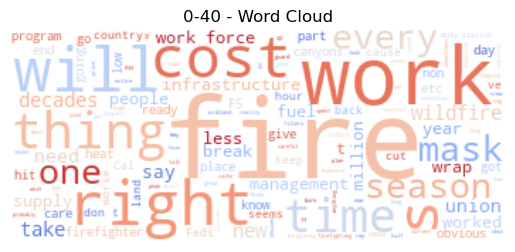

In [18]:
iterate_word_cloud(conf_score_dict_sixEight)

## Neutral Word Clouds - sixEight

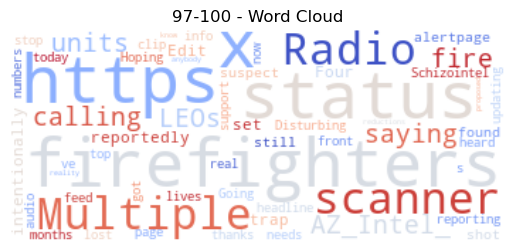

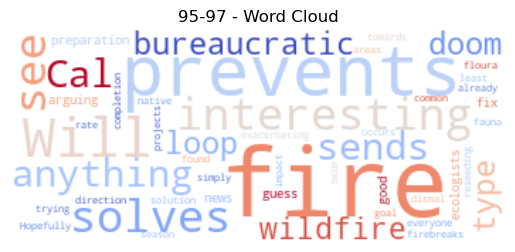

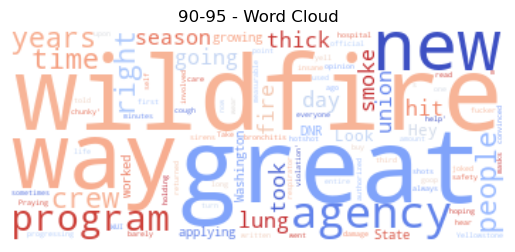

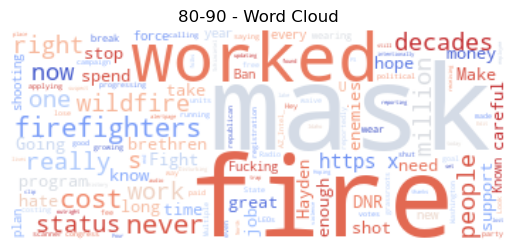

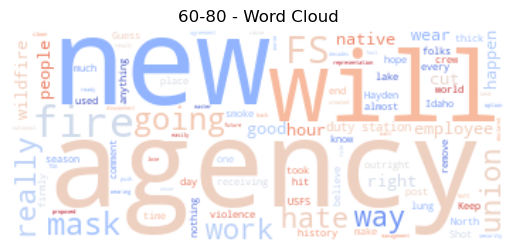

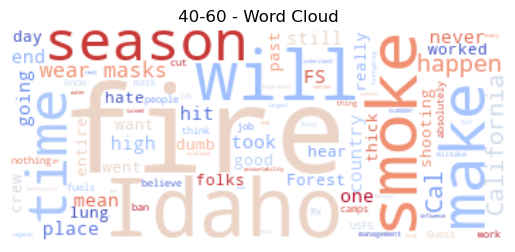

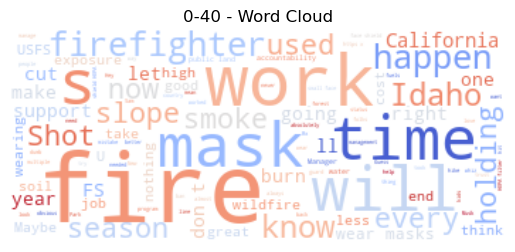

In [19]:
iterate_word_cloud(conf_score_dict_neutral_sixEight)

## Entailment Word Clouds - OG

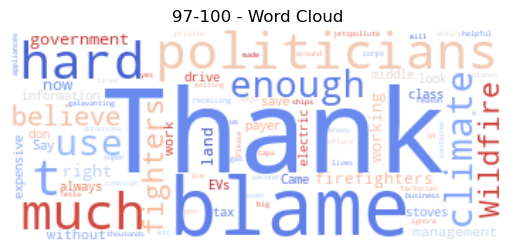

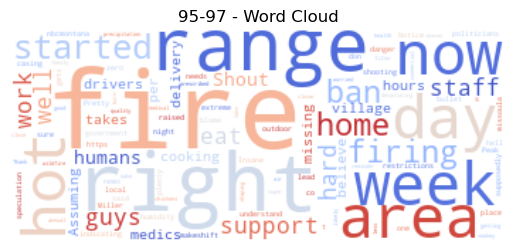

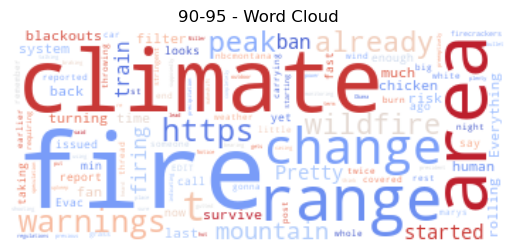

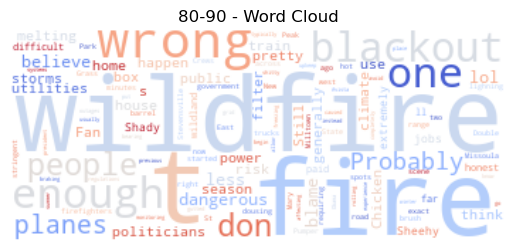

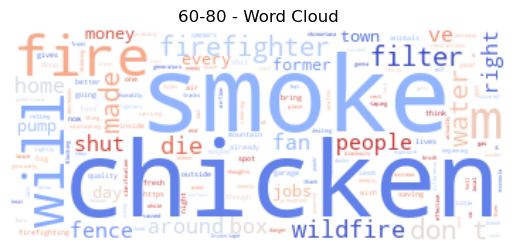

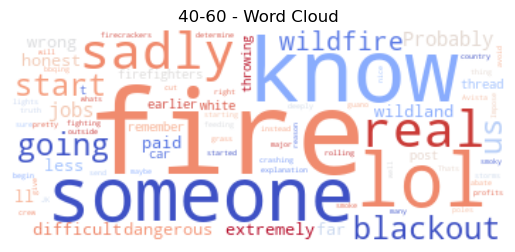

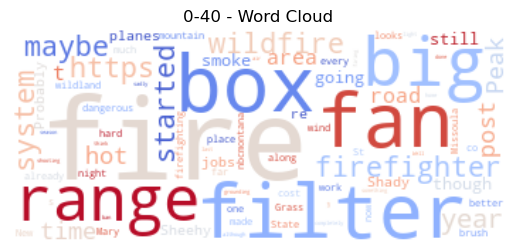

In [20]:
iterate_word_cloud(conf_score_dict_og)

## Neutral Word Clouds - OG

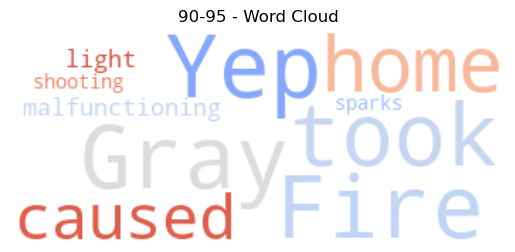

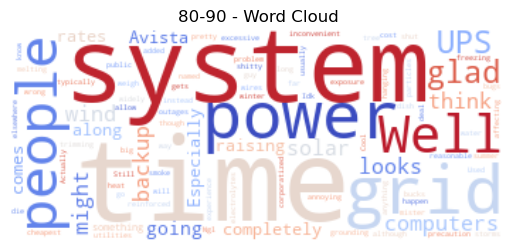

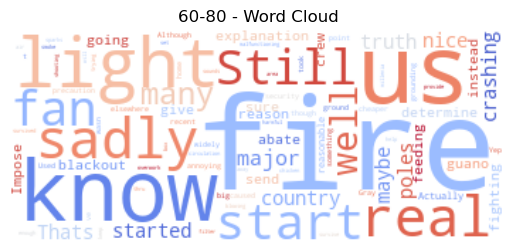

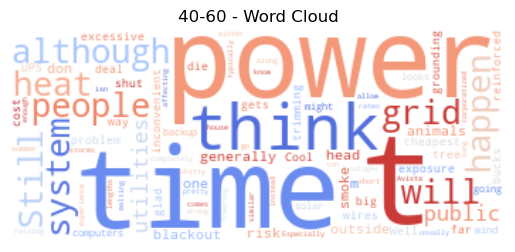

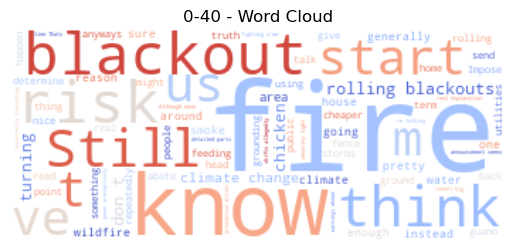

In [23]:
iterate_word_cloud(conf_score_dict_neutral_og)